# Combined notebook

## Scraping 2018 Results

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as snsplt

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import os

import matplotlib.cm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import seaborn as sns

from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

from sklearn.ensemble import BaggingClassifier
from sklearn import tree

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from bs4 import BeautifulSoup
import time
import requests

In [3]:
data_folder = "https://raw.githubusercontent.com/cdriscoll92/CS-109A-Final-Project/master/data/"
local_data_folder = "/Users/colleendriscoll/Dropbox/Classes/CS 109A/CS 109A Final project/data/"

In [4]:
politico_url_front = "https://www.politico.com/election-results/2018/"

In [5]:
## Reading in state abbreviations file to get the correct district ID columns
state_abbs = pd.read_csv(data_folder + "state_abbreviations_correspondence_table.csv")

## Politico site formatting for names
states = list(state_abbs.state_name.str.lower().values)
states_lower = [x.replace(" ", "-") for x in states]

In [6]:
def BS_html_parsed_from_html(URL):
    ## requires BeautifulSoup, time, requests
    time.sleep(2)
    bs_out = BeautifulSoup(requests.get(URL).text, "html.parser")
    return(bs_out)


In [ ]:
results_2018 = {'district': [],
               'party': [],
               'votes': []}
for i, abb in enumerate(state_abbs.state_abb):
    state_url = politico_url_front + states_lower[i]
    ## Get state page
    BS_page_state_i = BS_html_parsed_from_html(state_url)

    ## Figure out how many districts there are in the state
    district_links = BS_page_state_i.findAll("div",\
                            {"class":"district-links"})

    ## At-large districts don't have links and are referenced
    ## differently from multi-district states    
    if len(district_links) >0:
        district_n = len(district_links[0].findAll("a"))
        districts_formatted = ['{num:02d}'.format(num=k) for k \
                            in range(1, district_n+1)]
    else:
        districts_formatted = ['00']

    ## Get district tables
    dist_ids = [abb+"-"+dist_i for dist_i in districts_formatted]
    for district in dist_ids:
        ## Get the section on the page for this district
        district_html = BS_page_state_i.findAll("section",
                                                {"id": district})
        ## Get the table where the results are
        results_table = district_html[0].findAll("tr")
        
        ## Table composed of headers and footers; only
        ## grab candidate/vote information
        last_candidate_index = len(results_table)-2
        for j in range(1, last_candidate_index):
            ## Get party and number of votes for each cand.
            party = results_table[j].find("td",
                                          {"class":"party"})
            votes = results_table[j].find("td",
                                          {"class":"vote-count"})

            ## Add these results to the results dictionary
            results_2018['district'].append(district)
            results_2018['party'].append(party.text)
            results_2018['votes'].append(votes.text)

results_2018_df = pd.DataFrame(results_2018)
results_2018_df.to_csv(local_data_folder + "election_results/2018_scraped.csv")

In [ ]:
## Redistricting variable

In [8]:
redist_data_path = "/Users/colleendriscoll/Dropbox/Classes/CS 109A/CS 109A Final project/redistricting/"

states_df = pd.read_csv(redist_data_path + "FIPS.csv")
states_df.head()
state_names = list(map(lambda x : str.lower(x) , states_df.name.values))
state_abbrs = list(states_df.abbr.values)
state_fips = list(states_df.fips_code.values)

In [9]:
def abbr_for_state(state_name, state_names, state_abbrs):
    try:
        i = state_names.index(state_name.lower())
    except ValueError:
        return None
    return state_abbrs[i]

def dist_id_from_lewis(state_name, lewis_no, at_large="1"):
    result_state = abbr_for_state(state_name, state_names, state_abbrs)
    if lewis_no == 0:
        result_num = at_large
    else:
        result_num = "{:d}".format(int(lewis_no))
    return "{}_{}".format(result_state, result_num)

def map_id_from_lewis(state_names, lewis_nos, at_large="1"):
    return np.array(list(map(lambda s, n : dist_id_from_lewis(s, n, "1"),
                             state_names, lewis_nos)))



No states have been redistricted to a single at large district since the 2000 census. So we will ignore at-large districts in order to further minimize errors in producing the data.

In [10]:
district_hist_df = pd.read_csv(
    redist_data_path +
    "e6311_post1948-shapeless.csv"
).sort_values(by=['congress', 'year', 'state_name', 'lewis_dist'])

# filter for date range
years_min = 2000
years_max = 2017
rows_in_years_range = (district_hist_df.year >= years_min) & (district_hist_df.year <= years_max)
district_hist_df = district_hist_df[rows_in_years_range]

In [11]:
# ignore at-large districts
district_hist_df = district_hist_df[district_hist_df.lewis_dist != 0]

In [12]:
LEWIS_MOD = 1000
FIPS_MOD = 1000000000 

def abbr_from_fips(fips):
    try:
        i = state_fips.index(fips)
    except ValueError:
        return None
    return state_abbrs[i]

def statename_from_fips(fips):
    try:
        i = state_fips.index(fips)
    except ValueError:
        return None
    return state_names[i]

def dist_id_from_geomuid(geomuid, at_large="1"):
    lewis = geomuid % LEWIS_MOD
    if lewis == 0 and at_large != "0":
        lewis = at_large
    fips_code = int(geomuid / FIPS_MOD)
    return "{}_{:d}".format(abbr_from_fips(fips_code), int(lewis))

def dists_from_geomuids(geomuids, at_large="1"):
    return np.array(list(map(lambda g : dist_id_from_geomuid(g, at_large), geomuids)))

def get_all_year_dist(df):
    # obtain a table of all congressional contests
    years = df.year.values
    dist_ids = dists_from_geomuids(df.geom_uid)
    data = { 'year' : years, 'dist_id' : dist_ids }
    return pd.DataFrame(data)

district_hist_df['dist_id'] = dists_from_geomuids(district_hist_df.geom_uid)
all_possible = get_all_year_dist(district_hist_df)

In [14]:
congress_info = pd.read_csv(redist_data_path+"congress_numbers.csv")

In [15]:
CON_START_MOD = 1000000
CON_END_MOD = 1000

def election_year(congress_no):
    results = congress_info[congress_info.congress == congress_no].congressional_election.values
    return results[0]

def congress_no(year):
    return congress_info[(congress_info.start <= year) & (congress_info.end > year)].congress.values[0]

def start_congress(geomuid):
    result = geomuid % FIPS_MOD
    result -= (result % CON_START_MOD)
    result /= CON_START_MOD
    return result

def end_congress(geomuid):
    result = geomuid % CON_START_MOD
    result -= (result % CON_END_MOD)
    result /= CON_END_MOD
    return result

def year_from_geomuid(geomuid):
    return election_year(start_congress(geomuid))


In [16]:
def get_redistricting(df, geom_uid_col, ignore_years=[]):  
    unique_districts = df[geom_uid_col].drop_duplicates().sort_values().values
    dist_id = dists_from_geomuids(unique_districts)
    get_years = np.vectorize(year_from_geomuid)
    years = get_years(unique_districts)
    redistricted = np.full(dist_id.shape[0], True, dtype=bool)
    data = {
            'year' : years,
            'dist_id' : dist_id,
            'redistricted' : redistricted
           }
    redist_df = pd.DataFrame(data)
    if len(ignore_years) > 0:
        redist_df = redist_df.loc[~redist_df.year.isin(ignore_years)]
    return redist_df

redist_ = get_redistricting(district_hist_df, 'geom_uid', ignore_years=list(range(1990,1999,2)))
print(redist_.shape)

(998, 3)


In [17]:
# validate by getting redistricting counts by year
def states_redistricting(df):
    get_state = lambda dist : dist[0:2]
    get_states_from_id = np.vectorize(get_state)
    states = get_states_from_id(df.dist_id.values)
    years = df.year.values
    data = {'year' : years, 'state' : states}
    return pd.DataFrame(data).drop_duplicates()

df_states = states_redistricting(redist_)
display(df_states.groupby(['year']).count())
display(df_states.loc[df_states.year.isin([1998, 2000])].sort_values(['year', 'state']))

display(redist_.head())

,state
year,
2000,2
2002,42
2004,4
2006,2
2012,43


,year,state
589,2000,NC
766,2000,TX


,year,dist_id,redistricted
7,2002,AL_1,True
8,2002,AL_2,True
9,2002,AL_3,True
10,2002,AL_4,True
11,2002,AL_5,True


In [18]:
def dists_for_state(state_abbr,dist_count):
    return ["{}_{}".format(state_abbr, c) for c in range(1, dist_count + 1)]

In [19]:
def latest_district_count(df, state_abbr):
    states = get_states_from_id(df.dist_id.values)
    state_i = states == state_abbr
    state_rows = df[state_i]
    latest_year = state_rows[state_rows.year == np.max(state_rows.year.values)]
    return latest_year.shape[0]

def generate_redist_rows(state, year, dist_count, is_redist=True):
    dists = []
    for i in range(1, dist_count + 1):
        dists.append("{}_{}".format(state, i))
    years = np.full(dist_count, year, dtype=int)
    redist = np.full(dist_count, is_redist, dtype=bool)
    data = { 'year' : years, 'dist_id' : dists, 'redistricted' : redist }
    return pd.DataFrame(data)

def generate_redist_multi(state_tuples):
    df = None
    for st in state_tuples:
        result = generate_redist_rows(st[0], st[1], st[2])
        if df is None:
            df = result
        else:
            df = df.append(result)
    return df

additional_redistricting = [("NC", 2016, 13),
                            ("PA", 2018, 18),
                            ("VA", 2016, 11)]
redist_df = redist_.append(generate_redist_multi(additional_redistricting), sort=False)
redist_df.sort_values(['year', 'dist_id']).to_csv(redist_data_path + "redist_2000-2018.csv",
                                                  index=False)

## Data Cleaning

In [21]:
## Reading in state abbreviations file to get the correct district ID columns
state_abbs = pd.read_csv(data_folder + "state_abbreviations_correspondence_table.csv")

In [22]:
## Grouping CLEA by district-year to get the 
## democratic share of the two-party vote
def group_to_D_vote(groupby_obj, democrat_code):
    ## Groupby object with "yr", "dist_id", "pty", ""
    years = []
    dist_ids = []
    dem_shares = []
    
    for name, group in groupby_obj:
        dem_share = 0
        years.append(group.yr.values[0])
        dist_ids.append(group.dist_id.values[0])

        if democrat_code in group.pty.values: ## If a Democrat ran
            total_votes = np.sum(group.cv1.values)
            dem_votes = np.sum(group.cv1[group.pty == democrat_code].values)
            dem_share = dem_votes/total_votes
        dem_shares.append(dem_share)
    
    dem_vote_share_dict = {'year': years,
                           'dist_id': dist_ids,
                           'dem_vote_share': dem_shares
                          }
    return(dem_vote_share_dict)


In [23]:
def clea_clean(clea_file_name, state_abb_df):
    ## Read in data
    clea_results = pd.read_csv(clea_file_name)
    democrat_code = 180
    republican_code = 583
    election_month_int = 11
    
    ## Subsetting to only Democrats and Republicans
    clea_results = clea_results[(clea_results.pty == democrat_code) | 
                                (clea_results.pty == republican_code)]
    ## Only general elections (November)
    clea_results = clea_results[clea_results.mn == election_month_int]

    ## Extracting district number from constituency name
    ## There are some states with only one district that then don't 
    ## have a district number listed -- therefore filling those NAs with 1s
    clea_results['dist_num'] = clea_results.cst_n.str.findall('[0-9]+').\
    str[0].fillna(1)
    
    ## Lowercase state name to match CLEA listing
    state_abb_df['state_name_lower'] = state_abb_df.state_name.str.lower()

    ## Merging CLEA with state abbrevation correspondence table
    clea_merged = pd.merge(clea_results, state_abb_df,
                              how = 'right',
                              left_on = 'sub',
                              right_on = 'state_name_lower')
    
    ## Creating distict ID variable to merge on later
    clea_merged['dist_id'] = clea_merged['state_abb']+ "_" + \
    clea_merged['dist_num'].astype(str)

    ## Grouping CLEA by district-year to get the democratic share of the 
    ## two-party vote
    grouped = clea_merged.groupby(['dist_id', 'yr'])
    
    dem_vote_share = pd.DataFrame(group_to_D_vote(grouped, 
                                                 democrat_code))
    
    return dem_vote_share

In [24]:
clea_cleaned = clea_clean(data_folder + "election_results/clea_20180507.csv",
                          state_abbs)

In [25]:
results_2018_df = pd.read_csv(local_data_folder + 
                           "election_results/2018_scraped_cleaned.csv")
grouped_2018 = results_2018_df.groupby(['dist_id', 'yr'])
results_2018 = pd.DataFrame(group_to_D_vote(grouped_2018, "D"))
election_results = pd.concat([clea_cleaned, results_2018],
                             ignore_index=True)

## Make sure that no observations were lost/added in the concatenation
assert (len(clea_cleaned)+ len(results_2018) ==\
        len(election_results)), \
"Combined DataFrame not same length as two DFs combined"

In [26]:

def drop_secondary_members(nominate_df):
    ## Support function for NOMINATE cleaning
    ## Districts where there was more than one member of Congress serving, 
    ## assign the one who voted the most number of times to the district
    multiple_member_districts = nominate_df.dist_id\
    [nominate_df.dist_id.duplicated()]
    
    nominate_df['main_member'] = 1
    for district in multiple_member_districts:
        member_votes = nominate_df.nominate_number_of_votes\
        [nominate_df.dist_id == district]

        orders = np.argsort(member_votes)

        lowest_score_index = nominate_df['main_member']\
        [nominate_df.dist_id == district][orders == 0].index

        nominate_df.loc[lowest_score_index, 'main_member'] = 0

    ## Only keeping the main member in each district
    nominate_df = nominate_df[nominate_df.main_member == 1]
    nominate_df = nominate_df.drop(columns = ['main_member'], axis = 1,
                                   inplace = False)

    return nominate_df

In [27]:
def nominate_scores_clean(nom_file_name, cols_keep):
    nominate_scores = pd.read_csv(nom_file_name)
    nominate_scores = nominate_scores[cols_keep]
    
    ## Dropping president
    nominate_scores = nominate_scores[nominate_scores['state_abbrev']\
                                      != "USA"]

    ## Dropping members who didn't vote (they can't provide ideology measures then)
    missing_vote_num_indices = nominate_scores.nominate_number_of_votes.isna()\
    == True
    nominate_scores = nominate_scores[~missing_vote_num_indices]

    ## District ID column
    nominate_scores['dist_id'] = nominate_scores.state_abbrev + '_' + \
    nominate_scores.district_code.astype(str)

    nominate_scores = drop_secondary_members(nominate_scores)

    nominate_scores.drop('nominate_number_of_votes', axis = 1,
                        inplace = True)

    ## Election year during which this Congress was in session (not the one that
    ## produced this Congress!)
    session_length = 2
    congress_start_year = 1788
    nominate_scores['year'] = congress_start_year + session_length*\
    nominate_scores['congress']

    return nominate_scores

In [28]:
nominate_csvs = os.listdir(local_data_folder + "nominate_scores")
nominate_csvs_full = [local_data_folder + "nominate_scores/" + x \
                     for x in nominate_csvs]

In [29]:
nom_cols_keep = ['congress', 'icpsr', 'district_code',
                'state_abbrev', 'party_code', 'bioname', 'born',
                'nominate_dim1', 'nominate_dim2','nominate_number_of_votes',
                'nokken_poole_dim1', 'nokken_poole_dim2']

In [30]:
nom_combined = nominate_scores_clean(nominate_csvs_full[0],
                                nom_cols_keep)

for file_path in nominate_csvs_full[1:]:
    df = nominate_scores_clean(file_path, nom_cols_keep)
    nom_combined = nom_combined.append(df, ignore_index = True)
    

In [31]:
merged_elections_ideology = pd.merge(election_results, nom_combined, how = "left", 
                                     on = ["year", "dist_id"])
merged_elections_ideology['age'] = merged_elections_ideology['year'] - \
merged_elections_ideology['born']

merged_elections_ideology['dem_incumbent'] = 0
merged_elections_ideology['dem_incumbent'][merged_elections_ideology.party_code == 100] = 1
merged_elections_ideology = merged_elections_ideology.drop(\
    ['district_code','state_abbrev', 'bioname', 'born', 'party_code'],
                                                           axis = 1, inplace = False)

In [32]:
def lag_columns(df, by_cols, lag_cols, n_lag_terms):
    df.sort_values(by = by_cols,inplace=True)
    # 1) Create new columns
    new_col_names = [x+"_lag"+ str(i) for x in list(lag_cols) \
                     for i in range(1,n_lag_terms+1)]
    for new_col_name in new_col_names:
        df[new_col_name] = 'NaN'
    new_columns_dict = {x: [] for x in new_col_names}
    
    # Unique district IDs, for example
    groupby_values = df[by_cols[0]].unique()
    for val in groupby_values: ## in each district
        
        for lag_term in range(1, n_lag_terms+1): ## For each year lagged
            ## Get the right column name -- matches the one above
            new_col_name = lag_cols[0] + "_lag"+str(lag_term)
            ## Shift values using pd.DataFrame.shift()
            lagged_vals = df[df[by_cols[0]] == val][lag_cols[0]].shift(lag_term).values
            ## Insert lagged values back into the main data frame
            ## This is where the problem is
            new_columns_dict[new_col_name].extend(lagged_vals)
    
    for key in new_columns_dict:
        df[key] = new_columns_dict[key]
        
    return(df)

In [33]:
## Lagged vote share
merged_elections_ideology = lag_columns(merged_elections_ideology,
                                        ['dist_id', 'year'],
                                        ['dem_vote_share'], 1)
merged_elections_ideology = merged_elections_ideology.rename(
    columns={'dem_vote_share_lag1':'dem_prior_vote_share'})

In [34]:
ntl_df = pd.read_csv(local_data_folder + "national_government_makeup.csv")
merged_elections_ideology = pd.merge(merged_elections_ideology, ntl_df,
                                     how = "left", on = "year")

## President = binary(0,1) = [Republican, Democrat]
## House, Senate = float(0,1) = proportion seats held by Democrats

In [35]:
ACS_data = pd.read_csv(local_data_folder + "ACS_2005_2017.csv")

## Scaling columns to be proportions, not absolute numbers
columns_to_scale = ['bach_deg_num','black_pop','high_school_num','white_pop']
new_column_names = ['bachelor_deg_perc', 'black_perc', 'HS_diploma_perc', 'white_perc']
for i, colname in enumerate(columns_to_scale):
    ACS_data[new_column_names[i]] = ACS_data[colname]/ACS_data['total_pop']

ACS_data = ACS_data.drop(columns_to_scale, axis = 1, inplace = False)


In [36]:
ACS_data = pd.merge(ACS_data, state_abbs[['state_name', 'state_abb']],
                   how = "left", on = "state_name")

In [37]:
ACS_data['dist_id'] = ACS_data['state_abb'] + "_"+ \
ACS_data['district_num'].astype(str)

In [38]:
cols_to_drop = ['district_num', 'state_name', 'state_abb', 'total_pop']
ACS_data = ACS_data.drop(cols_to_drop, axis = 1, inplace = False)

In [39]:
## Using earliest data (2017) to predict the 2018 election
## So for the merge to work, we have to recode the year of 
## the 2017 data for 2018.

ACS_data['year'][ACS_data.year == 2017] = 2018

In [40]:
combined_data = pd.merge(merged_elections_ideology, ACS_data,
                        how = "left", on = ['dist_id', 'year'])

In [41]:
## Dropping NAs
combined_data = combined_data.dropna()

In [42]:
## Redistricting variable
def merge_redist(df, redist_df, year_col='year', dist_id_col='dist_id'):
    merged_df = df.merge(redist_df, on=(year_col, dist_id_col), how='left')
    merged_df.redistricted.fillna(0, inplace=True)
    return merged_df

redist_df = pd.read_csv(local_data_folder + "redist_2000-2018.csv")

combined_data = merge_redist(combined_data, redist_df)

In [43]:
combined_data.to_csv(local_data_folder + "combined_data.csv",
                     index=False)

## EDA

In [45]:
combined_data = pd.read_csv(local_data_folder + "combined_data.csv")

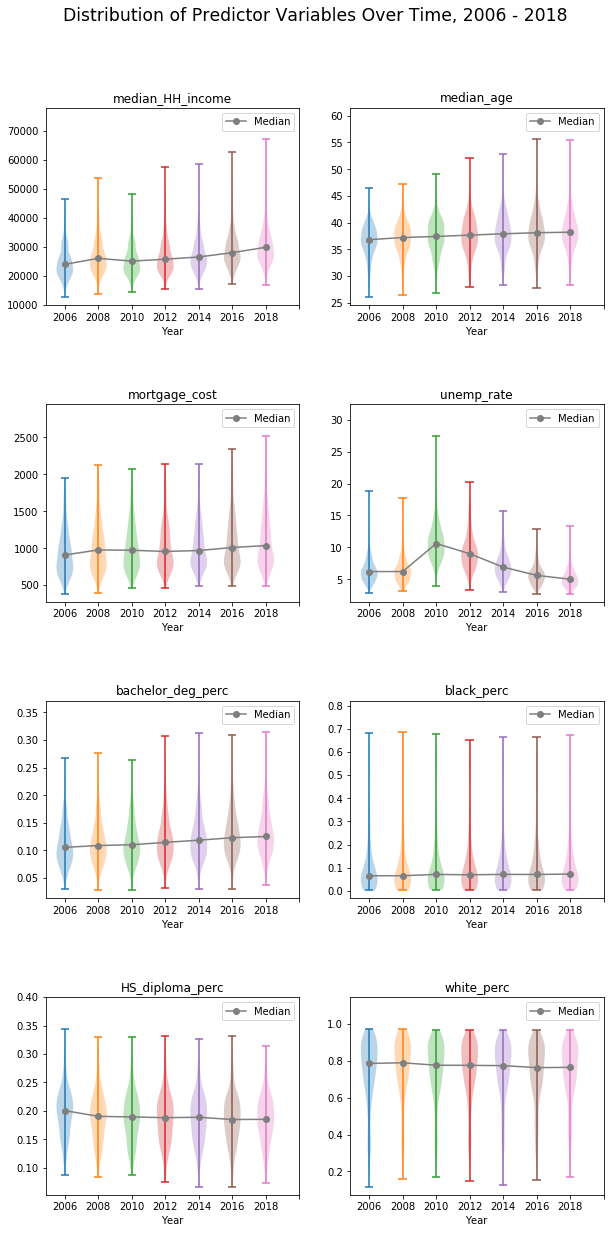

In [46]:
violin_plot_vars = ['median_HH_income', 'median_age','mortgage_cost',
                    'unemp_rate', 'bachelor_deg_perc', 'black_perc',
                    'HS_diploma_perc', 'white_perc']

years = combined_data.year.unique()

col_n, row_n = 2,4

fig, ax  = plt.subplots(nrows=row_n, ncols=col_n, figsize=(5*col_n,5*row_n))
fig.suptitle("Distribution of Predictor Variables Over Time, 2006 - 2018",
            y = 0.95, fontsize = "xx-large")
fig.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.5)
ax = ax.flatten()
for i, var in enumerate(violin_plot_vars):
    medians = []
    medians_x = []
    for j, y in enumerate(years):
        violin_plot_data = combined_data[var][combined_data.year == y]
        medians_x.append(j)
        medians.append(np.median(violin_plot_data.values))
        ax[i].violinplot(violin_plot_data.values,
                         positions = [j])
    ax[i].plot(medians_x, medians, "o-", label = "Median")
    ax[i].set_xticks([0,1,2,3,4,5,6,7])
    ax[i].set_xticklabels(years)
    ax[i].set_title(var)
    ax[i].set_xlabel("Year")
    min_val = np.min(combined_data[var])
    max_val = np.max(combined_data[var])
    min_max_range = max_val - min_val
    ax[i].set_ylim(min_val - 0.05*min_max_range,
                  max_val + 0.2*min_max_range)
    ax[i].legend()

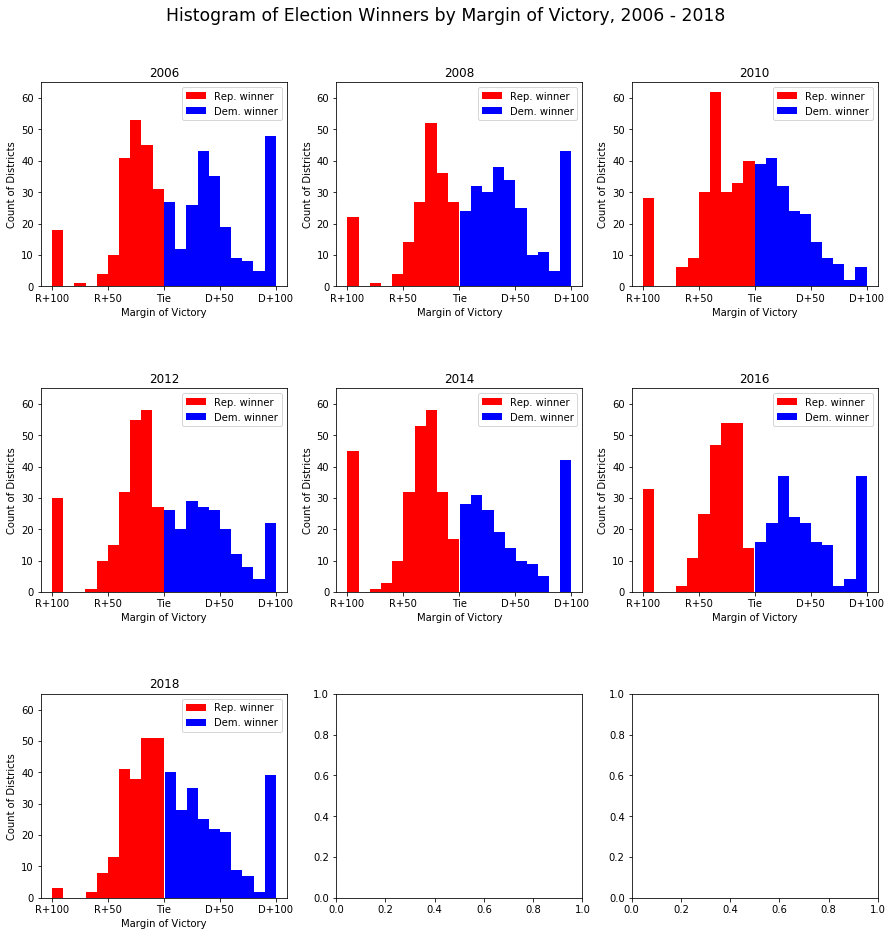

In [47]:
col_n, row_n = 3,3

fig, ax  = plt.subplots(nrows=row_n, ncols=col_n, figsize=(5*col_n,5*row_n))
fig.suptitle("Histogram of Election Winners by Margin of Victory, 2006 - 2018",
            y = 0.95, fontsize = "xx-large")
fig.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.2, hspace=0.5)
ax = ax.flatten()
for i, year in enumerate(combined_data.year.unique()):
    histogram_values = combined_data.dem_vote_share[
        combined_data.year == year].values
    republican_winners = [x for x in histogram_values if x < 0.5]
    democrat_winners = [x for x in histogram_values if x >= 0.5]
    ax[i].hist(republican_winners, color = "red",
                           label = "Rep. winner")
    ax[i].hist(democrat_winners, color = "blue",
                           label = "Dem. winner")
    ax[i].set_ylim(0, 65)
    ax[i].set_title(year)
    ax[i].set_xlabel("Margin of Victory")
    ax[i].set_ylabel("Count of Districts")
    ax[i].set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax[i].set_xticklabels(["R+100", "R+50", "Tie","D+50","D+100"])
    ax[i].legend()
plt.show();



## Baseline model

In [48]:
# Fit logistic regression on training data 

## Extracting 2016 data to use as training outcome
results_2016 = combined_data[combined_data.year == 2016]\
[['dist_id', 'year', 'dem_vote_share']]

results_2016.columns = ['dist_id', 'year', 'dem_vote_share_2016']
results_2016['dem_won_2016'] = np.round(results_2016.dem_vote_share_2016)
results_2016 = results_2016.drop('dem_vote_share_2016', axis = 1,
                                inplace = False)

train_data = combined_data[combined_data.year <2018]

train_data = pd.merge(train_data, results_2016[['dist_id', 'dem_won_2016']],
                     how = "left", on = 'dist_id')

results_2016 = train_data[train_data.year == 2016][['dist_id','dem_vote_share']]
results_2016.columns = ['dist_id', 'dem_vote_share_2016']

train_data = pd.merge(train_data, results_2016,
                     how = "left", on = "dist_id")

train_data = train_data.drop("dem_vote_share", axis = 1,
                            inplace = False)


In [49]:
train_data.to_csv(local_data_folder + 'train_data.csv',
                 index = False)

In [50]:
## Dropping unnecessary columns
cols_to_drop_for_train = ['dist_id', 'congress', 'icpsr']

# Fit logistic regression on training data 
data_to_fit_base = train_data.drop(cols_to_drop_for_train,
                                      axis = 1,
                                      inplace = False)
data_to_fit_base = data_to_fit_base.dropna(inplace = False)
data_to_fit_base.columns

Index(['year', 'nominate_dim1', 'nominate_dim2', 'nokken_poole_dim1',
       'nokken_poole_dim2', 'age', 'dem_incumbent', 'dem_prior_vote_share',
       'president', 'house', 'senate', 'median_HH_income', 'median_age',
       'mortgage_cost', 'unemp_rate', 'bachelor_deg_perc', 'black_perc',
       'HS_diploma_perc', 'white_perc', 'redistricted', 'dem_won_2016',
       'dem_vote_share_2016'],
      dtype='object')

In [51]:
## TRAINING SETS
x_train = data_to_fit_base
y_train = x_train.dem_won_2016.values


In [52]:
logreg_base = LogisticRegression(C=100000)
logreg_base.fit(x_train.dem_prior_vote_share.values.reshape(-1, 1),
            y_train)

LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [53]:
# Make Prediction and check the accuracy
y_train_probs=(logreg_base.predict_proba(x_train.dem_prior_vote_share\
                                     .values.reshape(-1, 1)))

train_accuracy = logreg_base.score(x_train.dem_prior_vote_share\
                               .values.reshape(-1, 1),
                            y_train)*100

print('Accuracy of baseline logistic regression classifier on train set: ',
      np.round(train_accuracy, 2), "%", sep = "")


Accuracy of baseline logistic regression classifier on train set: 81.57%


In [54]:
## Test results
y_test_continuous = combined_data[combined_data.year == 2018]['dem_vote_share']
y_test = np.round(y_test_continuous, 0)
x_test = combined_data[combined_data.year == 2018]['dem_prior_vote_share']

test_accuracy = logreg_base.score(x_test.values.reshape(-1, 1),
                                  y_test)*100

print('Accuracy of baseline logistic regression classifier on test set: ',
      np.round(test_accuracy, 2), "%", sep = "")

y_test_predict_probs=(logreg_base.predict_proba(x_test.values.reshape(-1, 1)))
y_test_predict_bool = (logreg_base.predict(x_test.values.reshape(-1, 1)))

Accuracy of baseline logistic regression classifier on test set: 86.9%


In [55]:
## True outcomes:

x_train_true = x_train['dem_prior_vote_share'].values
y_train_true = x_train['dem_vote_share_2016'].values

print(len(x_train_true) == len(y_train_true))

True


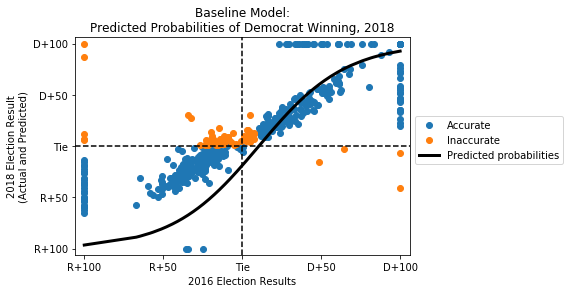

In [56]:

# Plot predicted probabilities
accurate = np.where(y_test_predict_bool == y_test.values)
inaccurate = np.where(y_test_predict_bool != y_test.values)
## Data
plt.plot(x_test.values[accurate],
         y_test_continuous.values[accurate], "o",
        label = "Accurate")
plt.plot(x_test.values[inaccurate],
         y_test_continuous.values[inaccurate], "o",
        label = "Inaccurate")
plt.plot(x_test.values[np.argsort(y_test_predict_probs[:,1])],
         y_test_predict_probs[:,1][np.argsort(y_test_predict_probs[:,1])],
         '-',linewidth = 3, color = "k",
         label='Predicted probabilities')
## 50% lines
plt.axhline(0.5, linestyle = "--", color = "black")
plt.axvline(0.5, linestyle = "--", color = "black")
plt.xlabel('2016 Election Results')
plt.ylabel('2018 Election Result\n(Actual and Predicted)')
plt.title('Baseline Model:\nPredicted Probabilities of Democrat Winning, 2018')
plt.xticks([0, 0.25, 0.5, 0.75, 1],
          ["R+100", "R+50", "Tie","D+50","D+100"])
plt.yticks([0, 0.25, 0.5, 0.75, 1],
          ["R+100", "R+50", "Tie","D+50","D+100"])
plt.xlim(-0.03, 1.03)
plt.ylim(-0.03, 1.03)
plt.legend(bbox_to_anchor=(1, 0.66))
plt.show();

In [57]:
## Lowest former vote share that predicts Democrat wins
left_bound = 255
right_bound = left_bound + 1
y_test_predict_probs[:,1][np.argsort(y_test_predict_probs[:,1])]
print(x_test.values[np.argsort(y_test_predict_probs[:,1])][right_bound])

0.5541502813410495


## Further Analysis

In [59]:
comb_data = pd.read_csv(local_data_folder + "combined_data.csv")
midterm_binary = [0 if comb_data.year[i] % 4 ==0 else 1\
                  for i in range(len(comb_data))]
comb_data['midterm'] = midterm_binary

In [60]:
#Test Data = Data for year 2018
testdata=comb_data[comb_data.year==2018]

#Train Data = Data for years other than 2018
traindata=comb_data[comb_data.year!=2018]

testdata.shape, traindata.shape

((435, 25), (2597, 25))

In [61]:
#List of predictors we want to use
predictors=['year','nokken_poole_dim1', 'nokken_poole_dim2', 'age',
            'dem_incumbent', 'dem_prior_vote_share',
            'president', 'house', 'senate', 'median_HH_income',
            'median_age', 'mortgage_cost', 'unemp_rate',
            'bachelor_deg_perc', 'black_perc',
            'HS_diploma_perc', 'white_perc',
            'redistricted', 'midterm']

#Columns to drop in Xtest and Xtrain
columns_to_drop=set(comb_data.columns) - set(predictors)

In [62]:
#Response Variable for test and train data sets = Democrat Vote Share
ytest=testdata.dem_vote_share
ytrain=traindata.dem_vote_share


#Xdata for test and train data
xtest=testdata.drop(columns_to_drop, axis=1, inplace = False)
xtrain=traindata.drop(columns_to_drop, axis=1, inplace = False)

In [63]:
corr_table_cols_to_drop = ['dist_id', 'congress', 'icpsr',
                          'nominate_dim1', 'nominate_dim2']
corr_table_data = comb_data.drop(corr_table_cols_to_drop,
                                axis = 1, inplace = False)
## Reordering columns
corr_table_data = corr_table_data[['year', 'dem_vote_share',
                                   'dem_prior_vote_share', 
                                   'dem_incumbent',
                                   'redistricted',
                                   'midterm',
                                   'president', 'house',
                                   'senate', 'nokken_poole_dim1',
                                   'nokken_poole_dim2', 'age',
                                   'white_perc', 'black_perc',
                                   'HS_diploma_perc',
                                   'bachelor_deg_perc',
                                   'unemp_rate', 'mortgage_cost',
                                   'median_HH_income', 'median_age']]
mask = np.zeros_like(corr_table_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(np.round(corr_table_data.corr(), 2),
            mask=mask, cmap=cmap,
            center=0,annot=True,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})
ax.set_title('Correlation heatmap between predictors and \
continuous outcome (`dem_vote_share`)')
plt.show();

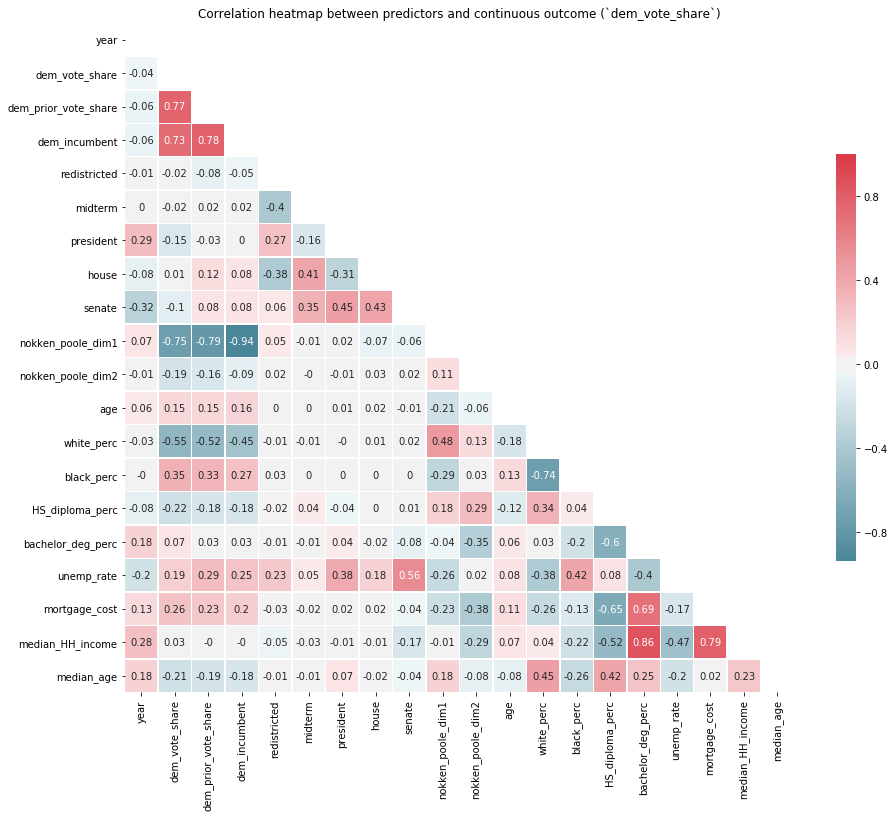

In [64]:
mask = np.zeros_like(corr_table_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(np.round(corr_table_data.corr(), 2),
            mask=mask, cmap=cmap,
            center=0,annot=True,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})
ax.set_title('Correlation heatmap between predictors and \
continuous outcome (`dem_vote_share`)')
plt.show();

In [65]:
#Convert the dem_vote_share to binary output
def get_binary(response):
    binary=[]
    for i in range(len(response)):
        if response.iloc[i] <0.5:
            out=0 
        else:
            out = 1 
        binary.append(out)
    binary=pd.DataFrame(binary)
    return binary

In [66]:
#binary response data
binarytest=get_binary(ytest)
binarytrain=get_binary(ytrain)

In [67]:
# Fit logistic regression on training data 

from sklearn.linear_model import LogisticRegression

logreg1 = LogisticRegression( C=100000)
logreg1.fit(xtrain, binarytrain)

# Make Prediction and check the accuracy
y_test_probs=(logreg1.predict_proba(xtest))
y_train_probs=(logreg1.predict_proba(xtrain))

logreg1_testscore=logreg1.score(xtest, binarytest)
logreg1_trainscore=logreg1.score(xtrain, binarytrain)

print('Accuracy of logistic regression classifier on \
train set: {0:.2f}%'.format(logreg1_trainscore*100))
print('Accuracy of logistic regression classifier on \
test set: {0:.2f}%'.format(logreg1_testscore*100))

Accuracy of logistic regression classifier on train set: 90.99%
Accuracy of logistic regression classifier on test set: 89.66%


In [68]:
scoretrain=[]
scoretest=[]
for i in range(1,25,2):
    RF1= RandomForestClassifier(max_depth=i, n_estimators=40)
    RF1.fit(xtrain, binarytrain)
    scoretrain.append(accuracy_score(binarytrain,  RF1.predict(xtrain)))
    scoretest.append(accuracy_score(binarytest,  RF1.predict(xtest)))

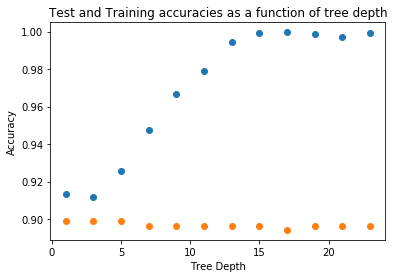

In [69]:
plt.plot(range(1,25,2), scoretrain,'o')
plt.plot(range(1,25,2), scoretest,'o')
plt.title("Test and Training accuracies as a function of tree depth")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy");

In [70]:
#The best tree depth = 3
RF2= RandomForestClassifier(max_depth=15, n_estimators=40)
RF2.fit(xtrain, binarytrain)

y_predRF_train = RF2.predict(xtrain)
y_predRF_test = RF2.predict(xtest)

#Perfromance Evaluation
trainRF_score = accuracy_score(binarytrain, y_predRF_train)
testRF_score = accuracy_score(binarytest, y_predRF_test)

print("Random Forest Accuracy, Training Set : {0:.2f}%".format(trainRF_score*100))
print("Random Forest Accuracy, Testing Set: {0:.2f}%".format(testRF_score*100))

Random Forest Accuracy, Training Set : 99.85%
Random Forest Accuracy, Testing Set: 89.89%


In [71]:
#Bagging Classifier
bag1 = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
bag1.fit(xtrain, binarytrain)
bag1_trainscore=bag1.score(xtrain,binarytrain)
bag1_testscore=bag1.score(xtest,binarytest)
print("Bagging Accuracy, Training Set : {0:.2f}%"\
      .format(bag1_trainscore*100))
print("Bagging Accuracy, Testing Set: {0:.2f}%"
      .format(bag1_testscore*100))

Bagging Accuracy, Training Set : 99.11%
Bagging Accuracy, Testing Set: 89.43%


In [72]:
#Scale Data to have mean = 1 and std =1
#Ridge regression on Scaled Data
xtrain_scaled=pd.DataFrame(preprocessing.scale(xtrain))
xtest_scaled=pd.DataFrame(preprocessing.scale(xtest))
ridge1= linear_model.Ridge(alpha=0.5)
ridge1.fit(xtrain,ytrain)

ridge1_testpred=pd.Series(ridge1.predict(xtest))
binarytest_ridgepred=get_binary(ridge1_testpred)

ridge1_trainpred=pd.Series(ridge1.predict(xtrain))
binarytrain_ridgepred=get_binary(ridge1_trainpred)


ridge1_testscore=accuracy_score(binarytest_ridgepred,binarytest)
ridge1_trainscore=accuracy_score(binarytrain_ridgepred,binarytrain)

print("Ridge Accuracy, Training Set : {0:.2f}%"\
      .format(ridge1_trainscore*100))
print("Ridge Accuracy, Testing Set: {0:.2f}%"\
      .format(ridge1_testscore*100))

Ridge Accuracy, Training Set : 91.41%
Ridge Accuracy, Testing Set: 90.11%


In [73]:
#Logistic Regression with cross-validation and L1 regularization (Lasso)

logregcv1 = LogisticRegressionCV(cv=5, penalty='l1',
                                 solver='liblinear').fit(xtrain, binarytrain)
logregcvlasso_testscore= logregcv1.score(xtest, binarytest) 
logregcvlasso_trainscore= logregcv1.score(xtrain, binarytrain) 

print("Lasso with CV Accuracy, Training Set : {0:.2f}%"\
      .format(logregcvlasso_trainscore*100))
print("Lasso with CV Accuracy, Testing Set: {0:.2f}%"\
      .format(logregcvlasso_testscore*100))

Lasso with CV Accuracy, Training Set : 91.45%
Lasso with CV Accuracy, Testing Set: 89.66%


In [74]:
#Logistic Regression with cross-validation and L2 regularization (Ridge)

logregcv2 = LogisticRegressionCV(cv=5, penalty='l2').fit(\
    xtrain, binarytrain)

logregcvridge_testscore= logregcv2.score(xtest, binarytest) 
logregcvridge_trainscore= logregcv2.score(xtrain, binarytrain) 

print("Ridge with CV Accuracy, Training Set : {0:.2f}%"\
      .format(logregcvridge_trainscore*100))
print("Ridge with CV Accuracy, Testing Set: {0:.2f}%"\
      .format(logregcvridge_testscore*100))

Ridge with CV Accuracy, Training Set : 75.86%
Ridge with CV Accuracy, Testing Set: 75.86%


In [75]:
accuracies_table = {'classifier':['Logistic Regression',
                                  'Logistic Regression with CV (Lasso)',
                                  'Logistic Regression with CV (Ridge)',
                                  'Linear Regression (Ridge)','Bagging',
                                  'Random Forest'],                    
                    'training accuracy':[logreg1_trainscore,
                                         logregcvlasso_testscore,
                                         logregcvridge_trainscore,
                                         ridge1_trainscore,                    
                                         bag1_trainscore,
                                         trainRF_score],
                    'test accuracy':[logreg1_testscore,
                                     logregcvlasso_testscore, 
                                     logregcvridge_testscore,
                                     ridge1_testscore,
                                     bag1_testscore,
                                     testRF_score]}

accuracies_table_df = pd.DataFrame(accuracies_table)

print("Summary of Models used:")
accuracies_table_df

Summary of Models used:


,classifier,training accuracy,test accuracy
0,Logistic Regression,0.909896,0.896552
1,Logistic Regression with CV (Lasso),0.896552,0.896552
2,Logistic Regression with CV (Ridge),0.758568,0.758621
3,Linear Regression (Ridge),0.914132,0.901149
4,Bagging,0.991144,0.894253
5,Random Forest,0.998460,0.898851


In [76]:
#Add Interaction Terms
poly = PolynomialFeatures(degree=3, interaction_only=False)
xtrain_interact=poly.fit_transform(xtrain)
xtest_interact=poly.fit_transform(xtest)

In [77]:
#Fit Logistic regression with interaction terms
logreg2 = LogisticRegression(C=1)
logreg2.fit(xtrain_interact, binarytrain)

# Make Prediction and check the accuracy
y_test_probs2=(logreg2.predict_proba(xtest_interact))
y_train_probs2=(logreg2.predict_proba(xtrain_interact))

logreg2_testscore=logreg2.score(xtest_interact, binarytest)
logreg2_trainscore=logreg2.score(xtrain_interact, binarytrain)

print('Accuracy of logistic regression classifier on train set: {0:.2f}%'\
      .format(logreg2_trainscore*100))
print('Accuracy of logistic regression classifier on test set: {0:.2f}%'\
      .format(logreg2_testscore*100))

Accuracy of logistic regression classifier on train set: 91.30%
Accuracy of logistic regression classifier on test set: 89.43%


In [78]:
## Test results
y_test_continuous = ytest
y_test = binarytest[0].values

y_test_predict_bool = (logreg2.predict(xtest_interact))
y_test_predict_cont = (logreg2.predict_proba(xtest_interact))

# Plot predicted probabilities
accurate_indices = np.where(y_test_predict_bool == y_test)
inaccurate_indices = np.where(y_test_predict_bool != y_test)


In [81]:
plot_cols = corr_table_data.columns.drop(['dem_vote_share', 'year',
                                         'president', 'house', 'senate',
                                          'midterm'])


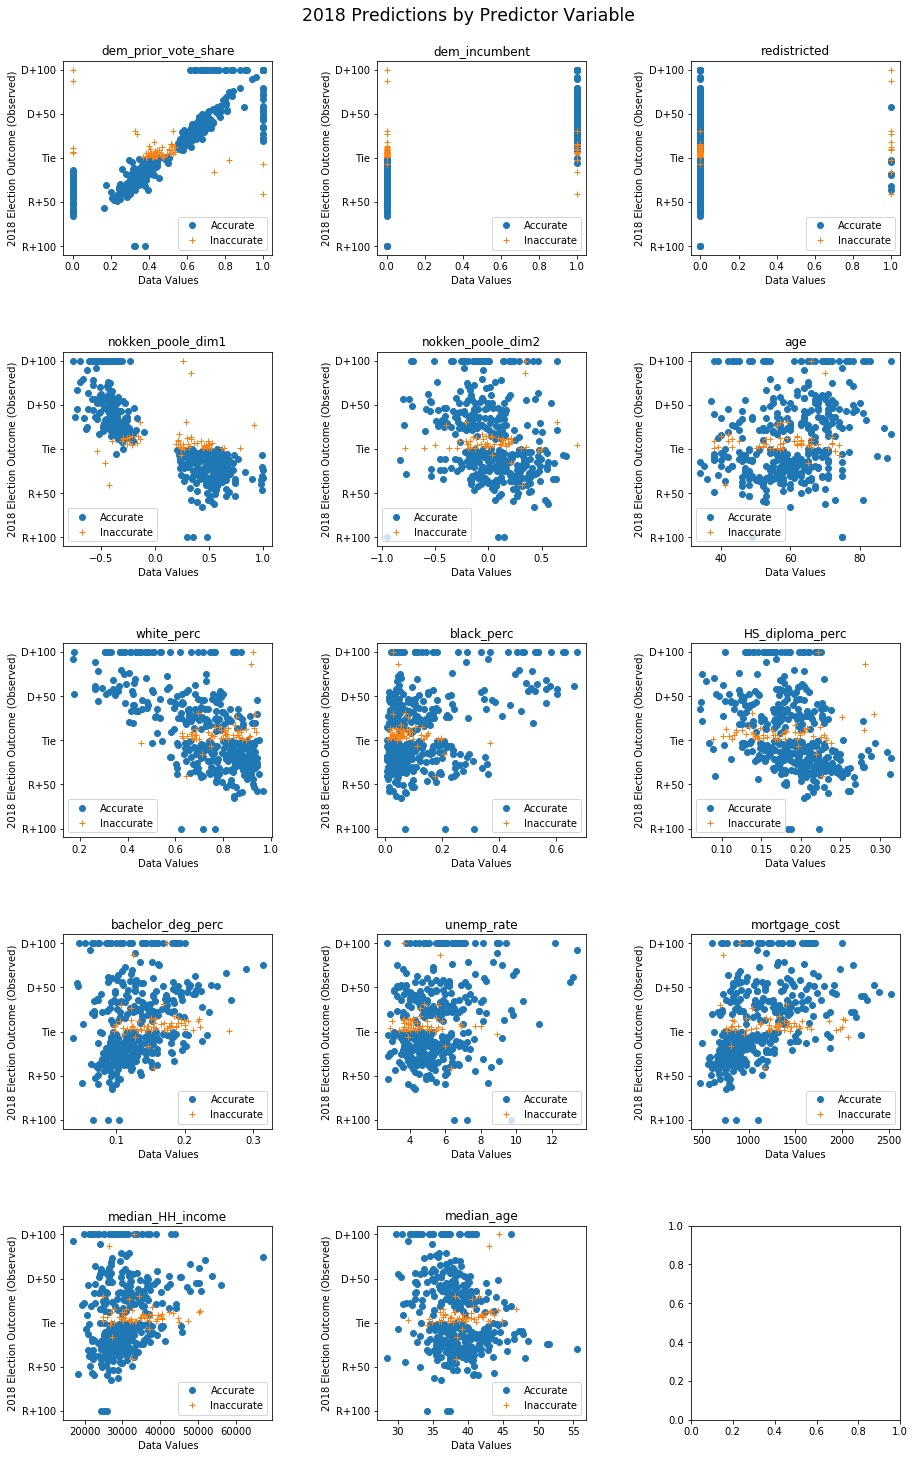

In [82]:
col_n, row_n = 3,5

fig, ax  = plt.subplots(nrows=row_n, ncols=col_n, figsize=(5*col_n,5*row_n))
fig.suptitle("2018 Predictions by Predictor Variable",
            y = 0.91, fontsize = "xx-large")
fig.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.5, hspace=0.5)
ax = ax.flatten()

for i, col in enumerate(plot_cols):
    x_values = xtest[col].values
    ## Data
    ax[i].plot(x_values[accurate],
             ytest.values[accurate], "o",
            label = "Accurate")
    ax[i].plot(x_values[inaccurate],
             ytest.values[inaccurate], "+",
            label = "Inaccurate")
    ax[i].set_title(col)
    ax[i].set_xlabel('Data Values')
    ax[i].set_ylabel('2018 Election Outcome (Observed)')
    ax[i].set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax[i].set_yticklabels(["R+100", "R+50", "Tie","D+50","D+100"])
    ax[i].legend()
plt.show();